# Problem description
In this notebook, deep-learning techniques are going to be applied to classify emotions in the audio domain. Concretelly, 7 cardinal emotions are going to be classified: anger,disgust, fear, happinnes, neutral,surprise and sadness.

To build the application, this tasks are followed in order:


*  Load audio files
*  Data visualization
*  Data normalization. (Optimization, augmentation...) 
*  Neural net model.

## Includes

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sbn
import librosa
import librosa.display
from IPython.display import Audio, display
import random
import re
import sklearn
import json
import tensorflow as tf
import os
import tensorflow.keras


from itertools import cycle
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Seaborn settings
sbn.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])




## User functions


In [14]:
def extract_name(file_path):
  tag = []
  text_j = ""
  if(re.search("(?<=OAF_)(.*?)(?=wav)",file_path)):
    tag.append("OAF")
    text = re.findall("(?<=OAF_)(.*?)(?=wav)",file_path)
    if(len(text)>1):
      text = [text_j.join(text)]
    text_spl = text[0].rsplit("\\",1)
    text_spl1 = re.findall("(?<=_)(.*?)(?=_)",text_spl[1])[0]
    text_spl2 = re.findall("(?<=_)(.*?)(?=\.)",text_spl[1])[0]
    text_spl2= text_spl2.split('_')[1]
    tag.append(text_spl2)
    tag.append(text_spl1)
    return tag
  elif(re.search("(?<=YAF_)(.*?)(?=wav)",file_path)):
    tag.append("YAF")
    text = re.findall("(?<=YAF_)(.*?)(?=wav)",file_path)
    if(len(text)>1):
      text = [text_j.join(text)]
    text_spl = text[0].rsplit("\\",1)
    text_spl1 = re.findall("(?<=_)(.*?)(?=_)",text_spl[1])[0]
    text_spl2 = re.findall("(?<=_)(.*?)(?=\.)",text_spl[1])[0]
    text_spl2= text_spl2.split('_')[1]
    tag.append(text_spl2)
    tag.append(text_spl1)
    return tag
  else:
    raise ValueError("Incorrect path provided")
  return [] 

def emotion_encoding(emotion):
  if(emotion == "angry"):
    return 0
  elif(emotion == "disgust"):
    return 1
  elif(emotion == "fear"):
    return 2
  elif(emotion == "happy"):
    return 3
  elif(emotion == "neutral"):
    return 4
  elif(emotion == "ps"):
    return 5  
  elif(emotion == "sad"):
    return 6
  else:
    return -1   


def mfcc_dataset( file_path, json_path, n_fft =1024, hop_length=512, n_mfcc=20):
  
  #dictionary to store the dataset
  data = {
      "emotion": [],
      "mfcc": [],
      "label": []
  }

  paths = glob(file_path) #list of all paths

  for path in paths:
    #save the emotion
    label = extract_name(path)
    data["emotion"].append(label[1])
    #load audio
    signal, sr = librosa.load(path)
    #Resize the audio signal to have the same length
    sps_3s = 66150  #22050 sps audio up to 3s, max duration 2.98.. s
    sig_dur = len(signal)/sr
    pad_len = sps_3s - len(signal)
    pad = np.zeros(pad_len)
    signal = np.concatenate((signal,pad), axis = 0)
    #process audio to obtain mfcc
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20, hop_length=512)
    #mfcc = mfcc.T
    data["mfcc"].append(mfcc.tolist())
    #save the label
    data["label"].append(emotion_encoding(label[1]))
  #save the dictionary in json file
  with open(json_path, "w") as f:
    json.dump(data, f, indent=4)


## Load audio files and data visualization

Reading in audio files and visulization in both time and frecuency domains.

In [3]:
audio_files = [os.path.normpath(i) for i in glob("C:/Users/joaso/Desktop/Machine_learning/Trabajo/TESS/*/*.wav")]

Author:OAF, Emotion:angry, Word:beg


shape y: (34093,)
sr: 22050


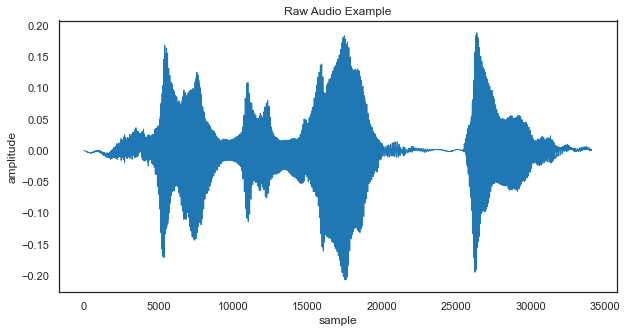

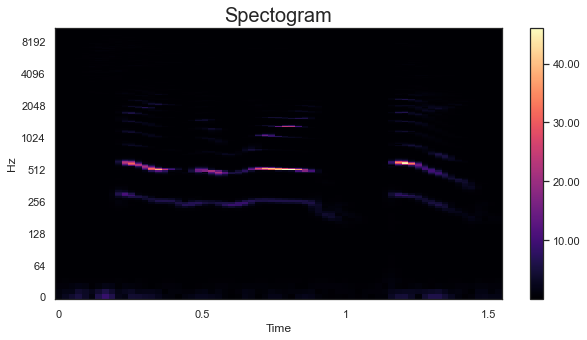

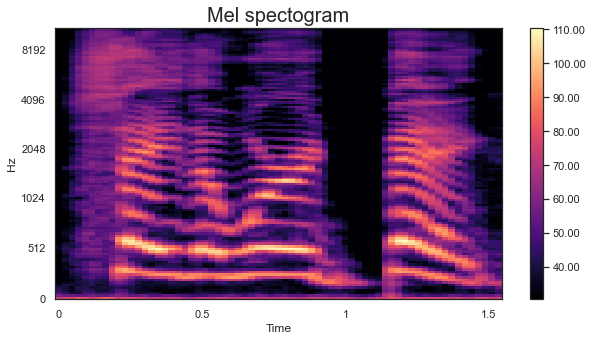

In [5]:
files_len = len(audio_files)
# Play audio file
rdm = random.randint(0, files_len-1)
tag = extract_name(audio_files[rdm])
print(f'Author:{tag[0]}, Emotion:{tag[1]}, Word:{tag[2]}')
display(Audio(audio_files[rdm], autoplay=False))
#Load audio file
y, sr = librosa.load(audio_files[rdm])
print(f'shape y: {y.shape}')
print(f'sr: {sr}')
#Plot audio time domain.
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                  xlabel = "sample",
                  ylabel = "amplitude",
                 color=color_pal[0])
plt.show()
#Time domain zoomed
# pd.Series(y[len(y)-800:len(y)-699]).plot(figsize=(10, 5),
#                   lw=1,
#                   title='Raw Audio Zoomed In Example',
#                  color=color_pal[2])
#plt.show()

#Spectogram, audio shown in the frecuency domain
sgram = librosa.stft(y)
#Uses the Decibel Scale instead of Amplitude
sgram_mag, _ = librosa.magphase(sgram)
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(sgram_mag,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

#Mel spectogram.
# Uses the Mel Scale instead of Frequency, it is a scale of pitches, such that 
#each unit is judged by listeners to be equal in pitch distance from the next.
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
# use the decibel scale to get the final Mel Spectrogram
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(mel_sgram,
                              x_axis='time',
                              y_axis='mel',
                              ax=ax)
ax.set_title('Mel spectogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()



The mel spectogram, shows a more detailed image of the armonic decomponsition of the sound wave. It uses the mel scale which is a scale of pitches, such that each unit is judged by listeners to be equal in pitch distance from the next.

### Comparation between emotions.
Now four mel spectograms of the same word but different emotions are compared, to see if the human eye can see the differences between each.

<Figure size 432x288 with 0 Axes>

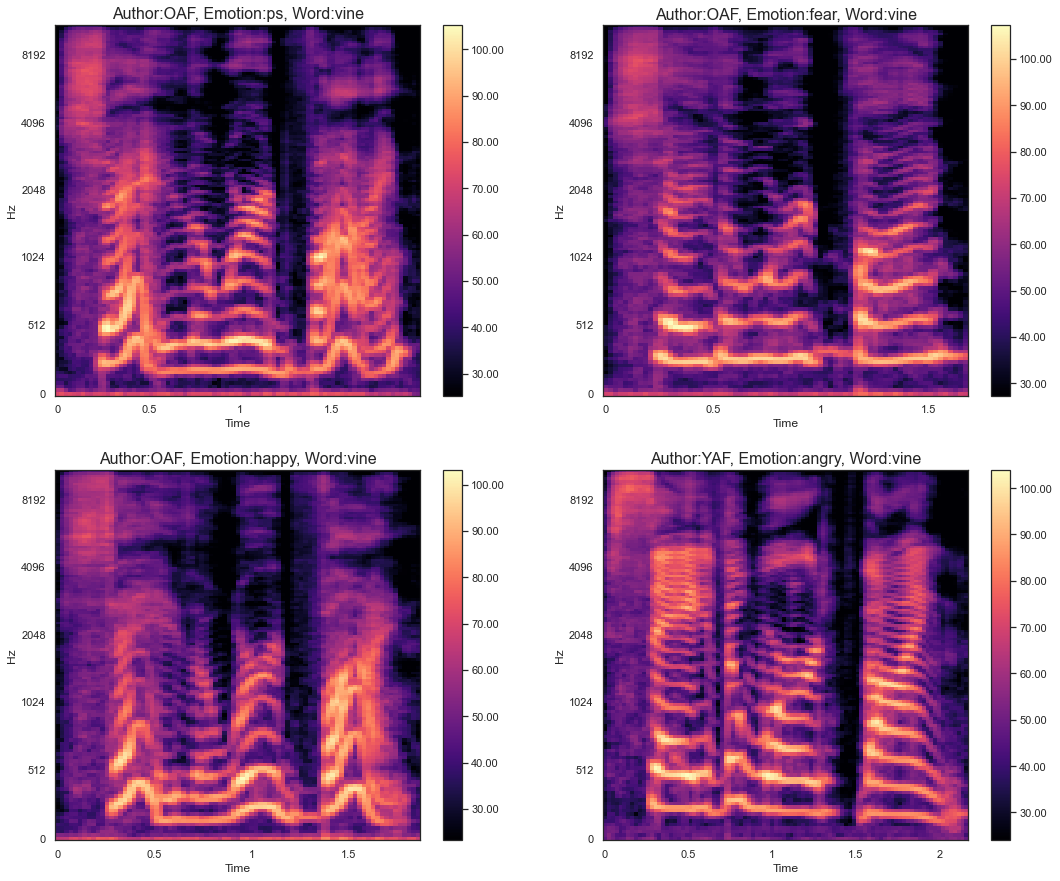

In [7]:
sub = 'vine'            #Change the word here
audio_comp = []
for text in audio_files:
    if sub in text:
        audio_comp.append(text)
rdm = random.sample(range(0, len(audio_comp)-1), 4)
tag1 = extract_name(audio_comp[rdm[0]])
tag2 = extract_name(audio_comp[rdm[1]])
tag3 = extract_name(audio_comp[rdm[2]])
tag4 = extract_name(audio_comp[rdm[3]])
#Load audio file
y1, sr1 = librosa.load(audio_comp[rdm[0]])
y2, sr2 = librosa.load(audio_comp[rdm[1]])
y3, sr3 = librosa.load(audio_comp[rdm[2]])
y4, sr4 = librosa.load(audio_comp[rdm[3]])
sgram1 = librosa.stft(y1)
sgram2 = librosa.stft(y2)
sgram3 = librosa.stft(y3)
sgram4 = librosa.stft(y4)
sgram_mag1, _ = librosa.magphase(sgram1)
sgram_mag2, _ = librosa.magphase(sgram2)
sgram_mag3, _ = librosa.magphase(sgram3)
sgram_mag4, _ = librosa.magphase(sgram4)
mel_scale_sgram1 = librosa.feature.melspectrogram(S=sgram_mag1, sr=sr1)
mel_scale_sgram2 = librosa.feature.melspectrogram(S=sgram_mag2, sr=sr2)
mel_scale_sgram3 = librosa.feature.melspectrogram(S=sgram_mag3, sr=sr3)
mel_scale_sgram4 = librosa.feature.melspectrogram(S=sgram_mag4, sr=sr4)
mel_sgram1 = librosa.amplitude_to_db(mel_scale_sgram1, ref=np.min)
mel_sgram2= librosa.amplitude_to_db(mel_scale_sgram2, ref=np.min)
mel_sgram3 = librosa.amplitude_to_db(mel_scale_sgram3, ref=np.min)
mel_sgram4 = librosa.amplitude_to_db(mel_scale_sgram4, ref=np.min)
plt.figure(1)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 15))
img = librosa.display.specshow(mel_sgram1,
                              x_axis='time',
                              y_axis='mel',
                              ax=ax[0,0])
ax[0,0].set_title('Author:{}, Emotion:{}, Word:{}'.format(tag1[0], tag1[1], tag1[2]), fontsize=16)
fig.colorbar(img, ax=ax[0,0], format=f'%0.2f')
img = librosa.display.specshow(mel_sgram2,
                              x_axis='time',
                              y_axis='mel',
                              ax=ax[0,1])
ax[0,1].set_title('Author:{}, Emotion:{}, Word:{}'.format(tag2[0], tag2[1], tag2[2]), fontsize=16)
fig.colorbar(img, ax=ax[0,1], format=f'%0.2f')
img = librosa.display.specshow(mel_sgram3,
                              x_axis='time',
                              y_axis='mel',
                              ax=ax[1,0])
ax[1,0].set_title('Author:{}, Emotion:{}, Word:{}'.format(tag3[0], tag3[1], tag3[2]), fontsize=16)
fig.colorbar(img, ax=ax[1,0], format=f'%0.2f')
img = librosa.display.specshow(mel_sgram4,
                              x_axis='time',
                              y_axis='mel',
                              ax=ax[1,1])
ax[1,1].set_title('Author:{}, Emotion:{}, Word:{}'.format(tag4[0], tag4[1], tag4[2]), fontsize=16)
fig.colorbar(img, ax=ax[1,1], format=f'%0.2f')
plt.show()


It can be observed some diferences in the mel spectograms of audio extracts saying the same word but with different emotions. For instance, the mel diagram for neutral emotion shows linearity in it's different pitches whereas the mel diagram for fear shows a constant increase and then decrease in them.
Can be concluded that mel spectograms compared to the other representations tested (spectogram and time-domain)  provide features with more information to train a neural network.
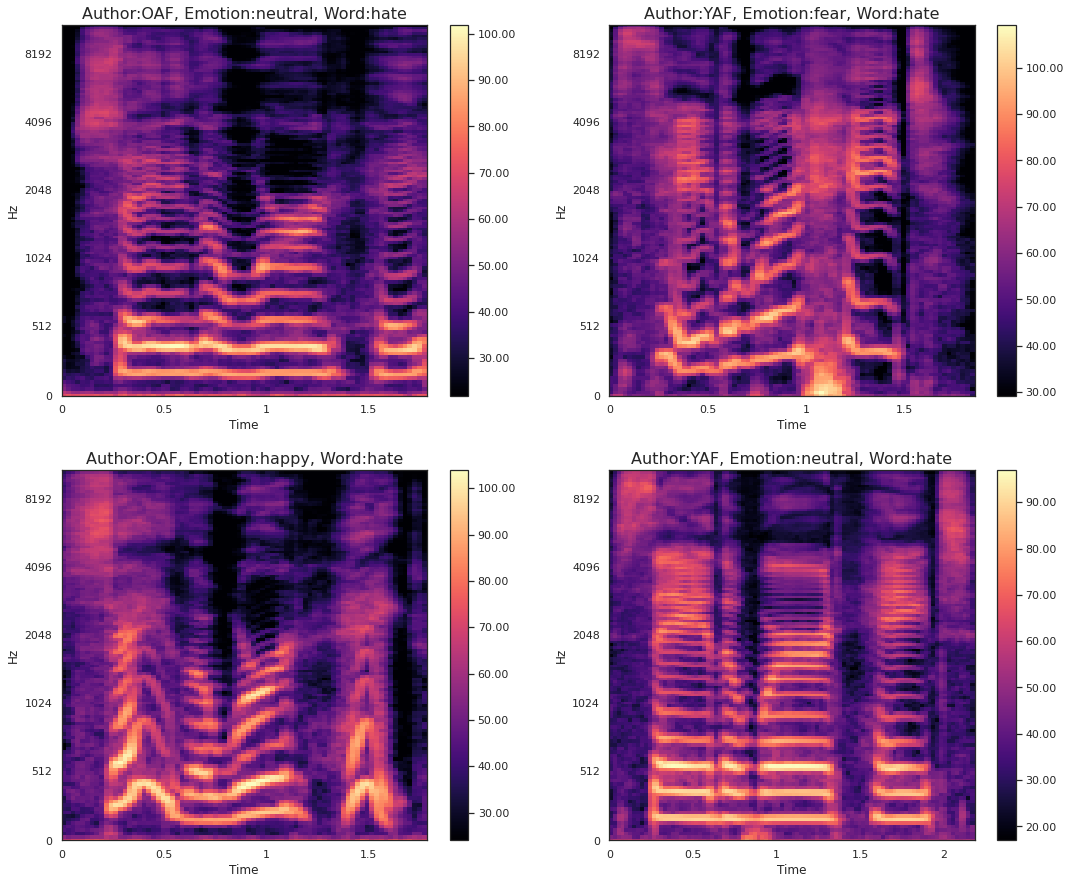

## Data normalization
### Optimization
The way melspectrograms are generated can be modified to reduce it's granularity changing their hiperparameters: 
*   Increasing the range of frecuencies, more ranges of frecuencies means more bands
*   Reducing the slide window used to compute the Short-time Fourier Transform (STFT). The intesity of each band is calculated more times for the sample.
*   Use of MFCC (Mel Frequency Cepstral Coefficients), The vital role of the cepstral coefficients is for eliminating
the speaker dependent characteristics.



<Figure size 432x288 with 0 Axes>

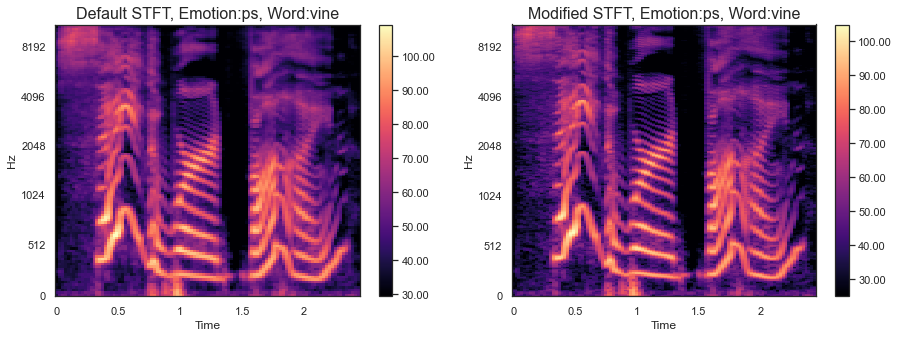

In [11]:
sub = 'vine'            #Change the word here
audio_comp = []
for text in audio_files:
    if sub in text:
        audio_comp.append(text)
rdm = random.sample(range(0, len(audio_comp)-1), 1)
tag1 = extract_name(audio_comp[rdm[0]])

#Load audio file
y1, sr1 = librosa.load(audio_comp[rdm[0]])
sgram1 = librosa.stft(y1)
sgram_mag1, _ = librosa.magphase(sgram1)
mel_scale_sgram1 = librosa.feature.melspectrogram(S=sgram_mag1, sr=sr1)
mel_sgram1 = librosa.amplitude_to_db(mel_scale_sgram1, ref=np.min)

mel_scale_sgramtuned = librosa.feature.melspectrogram(S = sgram_mag1, n_fft =1024, hop_length=256, fmin=0.0, fmax=10000,n_mels=256)
mel_sgram1tuned = librosa.amplitude_to_db(mel_scale_sgramtuned, ref=np.min)

plt.figure(1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
img = librosa.display.specshow(mel_sgram1,
                              x_axis='time',
                              y_axis='mel',
                              ax=ax[0])
ax[0].set_title('Default STFT, Emotion:{}, Word:{}'.format(tag1[1], tag1[2]), fontsize=16)
fig.colorbar(img, ax=ax[0], format=f'%0.2f')
img = librosa.display.specshow(mel_sgram1tuned,
                              x_axis='time',
                              y_axis='mel',
                              ax=ax[1])
ax[1].set_title('Modified STFT, Emotion:{}, Word:{}'.format(tag1[1], tag1[2]), fontsize=16)
fig.colorbar(img, ax=ax[1], format=f'%0.2f')
plt.show()

As wee see more definition can be obtained by incresing the number of mels and reducing the stft window length. (in this exaple mels*2 and window length/2

(20, 106)


C:\Users\joaso\anaconda3\envs\m_learning\lib\site-packages\sklearn\preprocessing\_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
C:\Users\joaso\anaconda3\envs\m_learning\lib\site-packages\sklearn\preprocessing\_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


<Figure size 432x288 with 0 Axes>

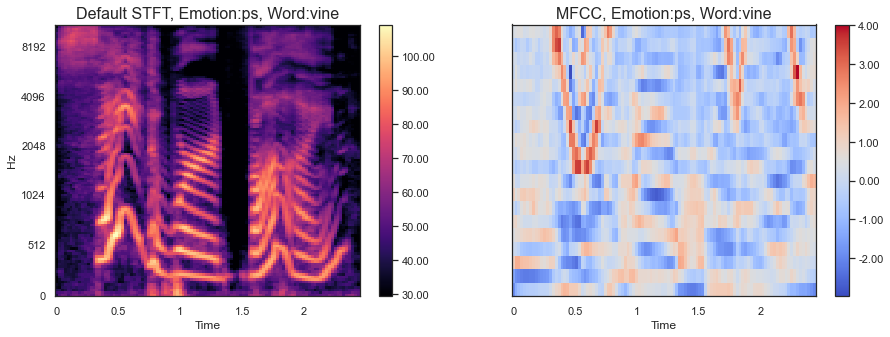

In [12]:
from numpy.core.fromnumeric import shape
mfcc = librosa.feature.mfcc(y=y1, sr=sr1)
# Center MFCC coefficient dimensions to the mean and unit variance
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
print(mfcc.shape)
plt.figure(2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
img = librosa.display.specshow(mel_sgram1,
                              x_axis='time',
                              y_axis='mel',
                              ax=ax[0])
ax[0].set_title('Default STFT, Emotion:{}, Word:{}'.format(tag1[1], tag1[2]), fontsize=16)
fig.colorbar(img, ax=ax[0], format=f'%0.2f')
img = librosa.display.specshow(mfcc,
                               sr = sr1,
                              x_axis='time',
                              ax=ax[1])
ax[1].set_title('MFCC, Emotion:{}, Word:{}'.format(tag1[1], tag1[2]), fontsize=16)
fig.colorbar(img, ax=ax[1], format=f'%0.2f')
plt.show()

## Duration of the audios 
Mean, max, min

In [13]:
paths = glob('C:/Users/joaso/Desktop/Machine_learning/Trabajo/TESS/*/*.wav') #list of all paths
min_duration = 1000
max_duration = 0
mean_dur = 0;
for path in paths:
  #load audio
  signal, sr = librosa.load(path)
  duration = len(signal)/sr
  mean_dur = mean_dur + duration
  if(duration <= min_duration):
   min_duration = duration
  if(duration >= max_duration):
    max_duration = duration
mean_dur = mean_dur/len(paths)
print(max_duration)
print(min_duration)
print(mean_dur)


2.9848072562358277
1.2541043083900227
2.0551482183349536


## First neural network

Deep neural network with convolution filters and a set of fully connected layers at the end. 
The inputs to this net are mfcc which are 2d arrays of shape (20,130),  20 mels and 130 samples (sample rate of 22050, 3 seconds of duration (padding with zeros has been perform), hop_length of 512). 

In [18]:
#dataset_path = '/content/drive/MyDrive/MasterEina/Redes_neuronales/Trabajo/TESS/*/*.wav'
json_path = os.path.normpath("C:/Users/joaso/Desktop/Machine_learning/Trabajo/data.json") 
#mfcc_dataset(dataset_path, json_path)
#Open json where data is stored
with open(json_path, "r") as fp:
  data = json.load(fp)

Train data shape: (1960, 20, 130), labels:(1960,)
Validation data shape: (420, 20, 130), labels:(420,)
Test data shape: (420, 20, 130), labels:(420,)

Validation data: (420, 20, 130)
[[-724.38853483 -721.8635382  -696.193233   ... -753.83622584
  -753.83622584 -753.83622584]
 [  38.42354792   39.54974805   28.87975138 ...    0.
     0.            0.        ]
 [  31.72858123   27.68132817   10.7865048  ...    0.
     0.            0.        ]
 ...
 [   8.96531354    7.31005635    7.4448467  ...    0.
     0.            0.        ]
 [   6.6951413     5.59582472   12.05435188 ...    0.
     0.            0.        ]
 [   3.88023906    4.78077667    8.2030828  ...    0.
     0.            0.        ]]


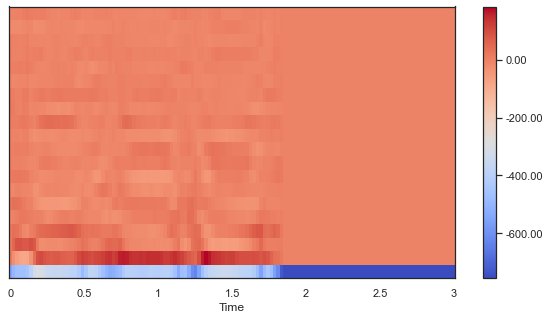

In [19]:
#Load data
inputs = np.array(data["mfcc"])
targets = np.array(data["label"])
#Split the data between train, test and validation

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.7
ratio_val = 0.15
ratio_test = 0.15

# Produces test split.
x_remaining, x_test, y_remaining, y_test = train_test_split(
    inputs, targets, test_size=ratio_test)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
x_train, x_val, y_train, y_val = train_test_split(
    x_remaining, y_remaining, test_size=ratio_val_adjusted)

print("Train data shape: " + str(x_train.shape) + ", labels:" + str(y_train.shape))
print("Validation data shape: " + str(x_val.shape) + ", labels:" + str(y_val.shape))
print("Test data shape: " + str(x_test.shape) + ", labels:" + str(y_test.shape) + "\n")
print("Validation data: " + str(x_val.shape))


print(x_val[0,:,:])
mfcc_feat = x_train[0,:,:]
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(mfcc_feat,
                              x_axis='time',
                              ax=ax)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()
#Check if this is correct

# y_train = tf.keras.utils.to_categorical(y_train, 7)
# y_val = tf.keras.utils.to_categorical(y_val, 7)
# y_test = tf.keras.utils.to_categorical(y_test, 7)

Shape:
(2800, 20, 130) -> 2800 examples (MFCCs) -> 20 mel bands, 3s of samples with sr 22050 sps -> 66150 samples, frame to calculate mel bands 512 -> that gives a total of 130 number of samples between successive frames, e.g., the columns of a spectrogram <br>
(2240, 20, 130) <br>
(560, 20, 130)

In [52]:

#First CNN net
np.random.seed(42)
tf.random.set_seed(42)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Reshape((20,130,1), input_shape=(20,130)))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='elu',input_shape=(20,130,1)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='elu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
#model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
# model.add(keras.layers.MaxPooling2D((2,2)))
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(units=64, activation='selu'))
#model.add(keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=64, activation='elu'))   #Con menos capas descomentar esta
#model.add(tf.keras.layers.Dense(units=32, activation='selu')) 
#model.add(keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=7, activation='softmax'))

#Compile the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam",
              metrics = ["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model.summary()



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 20, 130, 1)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 18, 128, 32)       320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 64, 32)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 9, 64, 32)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 62, 64)         18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 31, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 5952)             

In [53]:
#Train the model
history = model.fit(x_train, y_train, epochs = 20, validation_data=(x_val, y_val), callbacks=callback)
score = model.evaluate(x_test, y_test)

Epoch 1/20
62/62 [==============================] - 5s 66ms/step - loss: 6.3054 - accuracy: 0.3847 - val_loss: 1.6665 - val_accuracy: 0.4762
Epoch 2/20
62/62 [==============================] - 3s 45ms/step - loss: 0.7993 - accuracy: 0.7311 - val_loss: 0.5757 - val_accuracy: 0.7857
Epoch 3/20
62/62 [==============================] - 3s 46ms/step - loss: 0.3359 - accuracy: 0.8954 - val_loss: 0.1921 - val_accuracy: 0.9571
Epoch 4/20
62/62 [==============================] - 3s 46ms/step - loss: 0.2124 - accuracy: 0.9561 - val_loss: 1.1344 - val_accuracy: 0.6762
Epoch 5/20
62/62 [==============================] - 3s 47ms/step - loss: 0.3504 - accuracy: 0.9117 - val_loss: 0.1565 - val_accuracy: 0.9405
Epoch 6/20
62/62 [==============================] - 4s 61ms/step - loss: 0.0912 - accuracy: 0.9760 - val_loss: 0.3595 - val_accuracy: 0.8857
Epoch 7/20
62/62 [==============================] - 4s 58ms/step - loss: 0.0434 - accuracy: 0.9878 - val_loss: 0.0392 - val_accuracy: 0.9905
Epoch 8/20
62

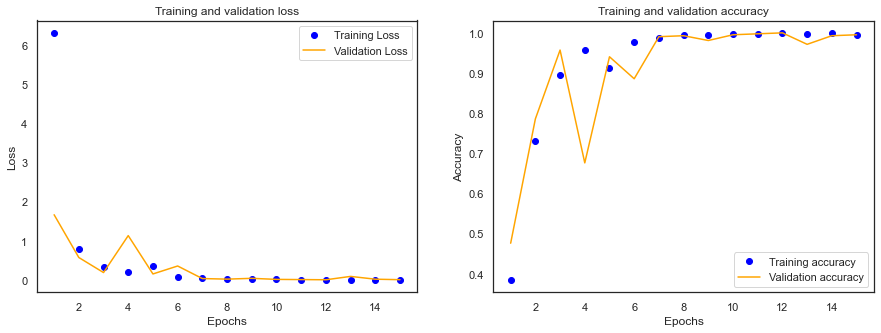

In [54]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,16)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

14/14 [==============================] - 0s 23ms/step - loss: 0.0521 - accuracy: 0.9929


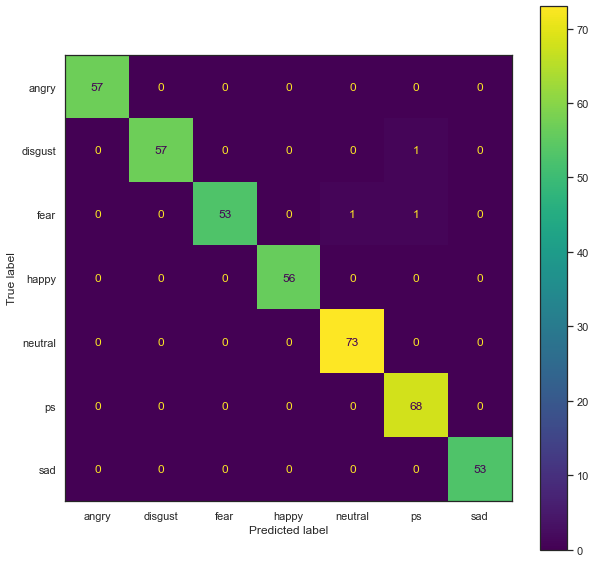

In [55]:
#Make prediction
test_loss, test_accuracy = model.evaluate(x_test, y_test)
y_predicted = model.predict(x_test)
y_predicted = y_predicted.argmax(axis=-1)
cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## "Second neural network"

